In [1]:
import numpy as np
import scipy.io as sio
import os

# Load the .mat files
data = sio.loadmat('HMP_start_converted.mat')

In [2]:
# Extract necessary data from the loaded .mat files
abundances = data['abundances']
inds_species = data['inds_species'].flatten() - 1
header = data['header']
GCNs = data['GCNs']
img_ids = data['img_ids'].flatten()  # Extract the first column to get the correct shape
keggs = data['keggs'].flatten()  # Extract the first column to get the correct shape

In [3]:
# Select samples
relabus = abundances[inds_species, :]  # Select species of index
inds_samps = (header[4, :] == 'Stool') & (header[7, :] == '1')  # Identify relevant samples
relabus = relabus[:, inds_samps]  # Select only the relevant samples

# Identify rows with all values <= 1e-6
inds2del = np.all(relabus <= 1e-6, axis=1)  # Identify rows with all values <= 1e-6
relabus = relabus[~inds2del, :]  # Remove these rows from relabus
G = GCNs > 0  # Convert GCNs to boolean
G = G[~inds2del, :]  # Remove the same rows from G
img_ids = img_ids[~inds2del]  # Remove the same indices from img_ids

# Identify columns with coverage < 0.8
coverage = np.sum(relabus[img_ids > 0, :], axis=0)  # Calculate coverage
inds2del = coverage < 0.8  # Identify columns with coverage < 0.8
relabus = relabus[:, ~inds2del]  # Remove these columns from relabus

# Identify columns in G where the sum is 0
inds2del = np.sum(G, axis=0) == 0  # Identify columns in G where the sum is 0
G = G[:, ~inds2del]  # Remove these columns from G
keggs = keggs[~inds2del]  # Remove corresponding elements from keggs
relabus = np.nan_to_num(relabus)  # Replace NaNs with 0
relabus = relabus / np.sum(relabus, axis=0, keepdims=True)  # Normalize relabus
mm  = relabus.shape[1]


In [4]:
import numpy as np
import os

G_orig = G.copy()  # Make a copy of G
files = os.listdir('KEGGs')  # List all files in the KEGGs directory
ko_all = []
ko_all_inds = []

# Loop through the files starting from the third file (index 2 in Python)
for filenum in range(0, len(files)):
    filename = os.path.join('KEGGs', files[filenum])
    ko2look = []

    # Open the file and read line by line
    with open(filename, 'r') as fid:
        for line in fid:
            sthis = line.strip().split()[0] 
            ko2look.append(int(sthis[1:]))  

    # ko2look: KO from each .txt
    
    
    Mthis = len(ko2look)
    inds2look = np.zeros(Mthis, dtype=int)

    # Find indices in keggs that match the ko2look values
    for j in range(Mthis):
        ind = np.where(keggs == ko2look[j])[0]
        if ind.size > 0:
            inds2look[j] = ind[0]

    inds2look = inds2look[inds2look != 0]  # Remove zero entries


    # Calculate the proportion of samples with G == 1
    G = G_orig[:, inds2look]  # Select columns from G_orig
    N, M = G.shape
    ps = np.sum(G, axis=0) / N  # Calculate the proportion of samples with G == 1

    if np.any(ps > 0.3):  # Check if any proportion is greater than 0.3
        print(filename)

    # Append the corresponding keggs values to ko_all
    ko_all.append(keggs[inds2look[np.argmax(ps > 0.3)]])
     # record keggs index for each keggs value
    ko_all_inds.append([inds2look[np.argmax(ps > 0.3)]])
   


G = G_orig[:,np.array(ko_all_inds).flatten()]
N, M = G.shape
mx = np.mean(relabus, axis=1)
# ?
dmx = np.zeros(M)
for j in range(M):
    dmx[j] = np.log10(np.mean(mx[G[:, j] == 1])) - np.log10(np.mean(mx[G[:, j] == 0]))
dmx[dmx < -6] = -6

ps = np.sum(G, axis=0) / N
n1 = np.sum(G, axis=0)
n1_orig = n1
dm_origs = dmx 


KEGGs\M00001.txt
KEGGs\M00004.txt
KEGGs\M00009.txt
KEGGs\M00022.txt
KEGGs\M00023.txt
KEGGs\M00024.txt
KEGGs\M00025.txt
KEGGs\M00049.txt
KEGGs\M00050.txt
KEGGs\M00051.txt
KEGGs\M00052.txt
KEGGs\M00115.txt
KEGGs\M00117.txt
KEGGs\M00120.txt
KEGGs\M00127.txt
KEGGs\M00144.txt
KEGGs\M00149.txt
KEGGs\M00958.txt
KEGGs\M00959.txt


In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 设置要绘制的柱状图数目
mm2plot = 30

# 对 relabus 的行求和并按降序排序，获取排序后的索引
sorted_inds_x = np.argsort(np.sum(relabus, axis=1))[::-1]

# 随机选择 mm2plot 个索引进行绘制
inds2plot = np.random.permutation(mm)[:mm2plot]

# 设置 N_vis 的值
N_vis = 100

# 转置 relabus 并选择要绘制的部分
xthis = relabus.T
xthis = xthis[inds2plot, :][:, sorted_inds_x]

# 合并第 N_vis+1 列及之后的所有列，并将结果存储在第 N_vis+1 列
xthis[:, N_vis] = np.sum(xthis[:, N_vis:], axis=1)

# 只保留前 N_vis+1 列
xthis = xthis[:, :N_vis+1]

xthis.shape

(30, 101)

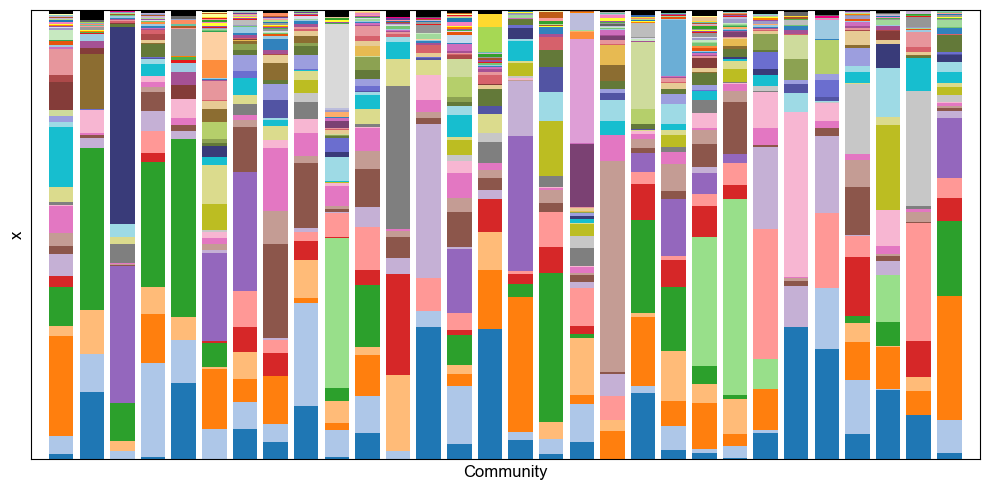

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 data 是一个形状为 (30, 101) 的二维数组
data = xthis

# 归一化数据，使得每列的和为1

# 创建颜色映射对象，包含30种颜色
colors = []
colors.extend(plt.cm.tab20(np.linspace(0, 1, 20)))
colors.extend(plt.cm.tab20b(np.linspace(0, 1, 20)))
colors.extend(plt.cm.tab20c(np.linspace(0, 1, 20)))
colors.extend(plt.cm.Set1(np.linspace(0, 1, 9)))
colors.extend(plt.cm.Paired(np.linspace(0, 1, 12)))
colors.extend(plt.cm.Set2(np.linspace(0, 1, 8)))
colors.extend(plt.cm.Accent(np.linspace(0, 1, 8)))
colors.extend(plt.cm.Set3(np.linspace(0, 1, 12)))
colors = colors[:100]
colors.append(([0,0,0,1]))  # 确保总共101种颜色

# 创建堆叠柱状图
fig, ax = plt.subplots()
x = np.arange(30)  # x轴上的点
bottom = np.zeros(30)  # 底部值的初始化

# 绘制堆叠柱状图
for i in range(101):
    ax.bar(x, data[:, i], bottom=bottom, color=colors[i], edgecolor='none')
    bottom += data[:, i]  # 更新底部值，使得下一个柱子在上一个柱子的顶部

# 设置坐标轴和图形属性
ax.set_xlim([-1, 30])
ax.set_ylim([0, 1])
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylabel('x', fontsize=12, fontname='Arial')
ax.set_xlabel('Community', fontsize=12, fontname='Arial')
ax.tick_params(width=0.5, length=0.0)
ax.minorticks_off()
ax.tick_params(direction='out')
fig.set_size_inches(10, 5) 
fig.tight_layout() 

# 显示图形
plt.show()


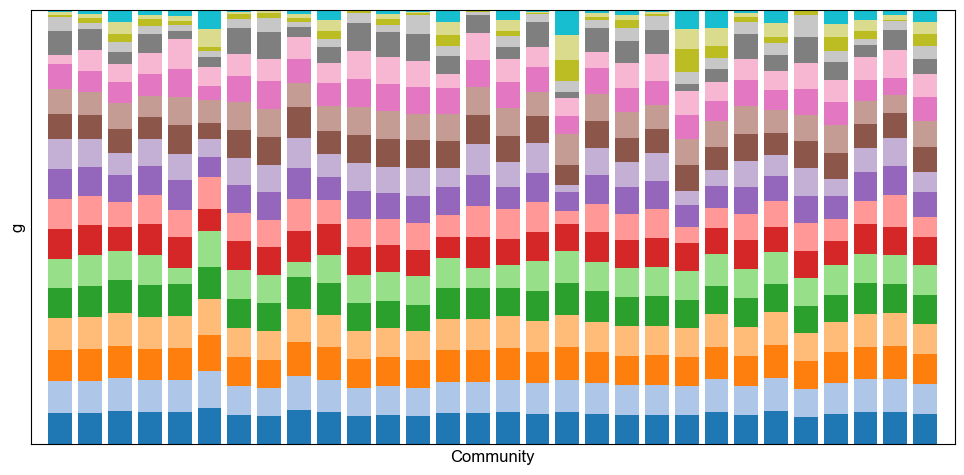

In [7]:
gs = np.dot(relabus.T, G).T
# 排序数据并选择绘制部分
gs = gs / np.sum(gs, axis=0, keepdims=True)
sorted_inds_g = np.argsort(np.mean(gs, axis=1))[::-1]
gs = gs[sorted_inds_g][:, :30]

colors = []
colors.extend(plt.cm.tab20(np.linspace(0, 1, 20)))
colors.extend(plt.cm.tab20b(np.linspace(0, 1, 20)))
colors.extend(plt.cm.tab20c(np.linspace(0, 1, 20)))
colors.extend(plt.cm.Set1(np.linspace(0, 1, 9)))
colors.extend(plt.cm.Paired(np.linspace(0, 1, 12)))
colors.extend(plt.cm.Set2(np.linspace(0, 1, 8)))
colors.extend(plt.cm.Accent(np.linspace(0, 1, 8)))
colors.extend(plt.cm.Set3(np.linspace(0, 1, 12)))
colors = colors[:100]

# 创建图形和坐标轴
fig, ax = plt.subplots()
ax.set_position([0.1, 0.1, 0.8, 0.8])

# 绘制堆叠柱状图
x = np.arange(30)  # x轴上的点
bottom = np.zeros(30)  # 底部值的初始化
bh = []
for i in range(gs.shape[0]):
    b = ax.bar(x, gs[i], bottom=bottom, color=colors[i], edgecolor='none')
    bh.append(b)
    bottom += gs[i]  # 更新底部值，使得下一个柱子在上一个柱子的顶部

ax.set_xlim([-1, 30])
ax.set_ylim([0, 1])
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylabel('g', fontsize=12, fontname='Arial')
ax.set_xlabel('Community', fontsize=12, fontname='Arial')
ax.tick_params(width=0.5, length=0.0)
ax.minorticks_off()
ax.tick_params(direction='out')
fig.set_size_inches(10, 5) 
fig.tight_layout() 

# 显示图形
plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plt


plt.rcParams['font.family'] = 'Arial'
def ConvertToG(G, relabus):
    temp = np.dot(relabus.T, G).T   
    return temp / np.sum(temp, axis=0, keepdims=True)

#一种相似度计算方法
def CalculateBC(xthis, ythis):
    return 1 - np.sum(np.minimum(xthis, ythis))

# 计算每列与均值的相似度度量
def CalculateDs(xs):
    mm = xs.shape[1]
    xm = np.mean(xs, axis=1, keepdims=True)
    ds = np.zeros(mm)
    for iii in range(mm):
        ds[iii] = CalculateBC(xs[:, iii], xm.flatten())
    return ds

dg_orig = CalculateDs(ConvertToG(G, relabus))
dg_m_orig = np.mean(dg_orig)

# 模拟
ns = int(1e4)
dg_m_shfls = np.zeros(6)

temp = relabus
for i in range(6):
    dg_m_shfls[i] = np.mean(CalculateDs(ConvertToG(G, temp)))
    temp.T[0]*=2

In [10]:
import numpy as np
import matplotlib.pyplot as plt


plt.rcParams['font.family'] = 'Arial'

def shuffle_matrix_rows(matrix):
    # 对矩阵进行复制，防止原矩阵被修改
    shuffled_matrix = np.copy(matrix)
    # 对于矩阵中的每一行进行随机排列
    for row in shuffled_matrix:
        np.random.shuffle(row)
    return shuffled_matrix


def ConvertToG(G, relabus):
    temp = np.dot(relabus.T, G).T
    return temp / np.sum(temp, axis=0, keepdims=True)

#一种相似度计算方法
def CalculateBC(xthis, ythis):
    return 1 - np.sum(np.minimum(xthis, ythis))

# 计算每列与均值的相似度度量
def CalculateDs(xs):
    mm = xs.shape[1]
    xm = np.mean(xs, axis=1, keepdims=True)
    ds = np.zeros(mm)
    for iii in range(mm):
        ds[iii] = CalculateBC(xs[:, iii], xm.flatten())
    return ds

dg_orig = CalculateDs(ConvertToG(G, relabus))
dg_m_orig = np.mean(dg_orig)

# 模拟
ns = int(1e4)

dg_m_shfls = np.zeros(ns)
for rep in range(ns):
    # 随机按行打乱矩阵G
    G_shuffled = G[np.random.permutation(N), :]
    dg_m_shfls[rep] = np.mean(CalculateDs(ConvertToG(G_shuffled, relabus)))


dg_m_shfls_row = np.zeros(ns)
for rep in range(ns):
    # 打乱每一行G的分布
    #G_shuffled = G[np.random.permutation(N), :]
    G_shuffled = shuffle_matrix_rows(G)
    dg_m_shfls_row[rep] = np.mean(CalculateDs(ConvertToG(G_shuffled, relabus)))

#fig, ax = plt.subplots()

dg_m_shfls_col = np.zeros(ns)
for rep in range(ns):
    # 打乱每一列G的分布
    #G_shuffled = G[np.random.permutation(N), :]
    G_shuffled = shuffle_matrix_rows(G.T).T
    dg_m_shfls_col[rep] = np.mean(CalculateDs(ConvertToG(G_shuffled, relabus)))

#fig, ax = plt.subplots()



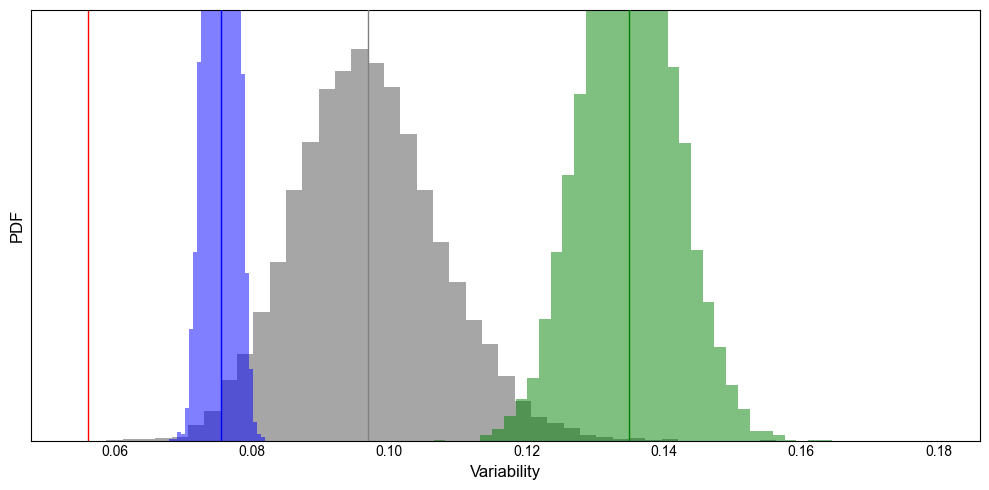

: 

In [11]:
# 可视化
fig, ax = plt.subplots()
dg_m_shfls = dg_m_shfls[~np.isnan(dg_m_shfls)]
xthis = dg_m_shfls
xmin = np.min(xthis)
xmax = np.max(xthis)
bins = np.linspace(xmin * 0.9, xmax * 1.1, 50)
h = ax.hist(xthis, bins=bins, density=True, edgecolor='none', facecolor='grey',alpha=0.7, zorder=1)

# 添加原始 dg 的直线
ymax = np.max(h[0])
ax.plot([dg_m_orig, dg_m_orig], [0, ymax * 1.1], '-', linewidth=1, color='red')
ax.plot([np.mean(dg_m_shfls), np.mean(dg_m_shfls)], [0, ymax * 1.1], '-', linewidth=1, color='grey', zorder=5)

xthis = dg_m_shfls_row
xmin = np.min(xthis)
xmax = np.max(xthis)
bins = np.linspace(xmin * 0.9, xmax * 1.1, 50)
h = ax.hist(xthis, bins=bins, density=True, facecolor='blue',alpha=0.5, zorder=1)
ax.plot([np.mean(dg_m_shfls_row), np.mean(dg_m_shfls_row)], [0, ymax * 1.1], '-', linewidth=1, color='blue', zorder=5)

dg_m_shfls_col = dg_m_shfls_col[~np.isnan(dg_m_shfls_col)]
xthis = dg_m_shfls_col
xmin = np.min(xthis)
xmax = np.max(xthis)
bins = np.linspace(xmin * 0.9, xmax * 1.1, 50)
h = ax.hist(xthis, bins=bins, density=True, facecolor='green',alpha=0.5, zorder=1)
ax.plot([np.mean(dg_m_shfls_col), np.mean(dg_m_shfls_col)], [0, ymax * 1.1], '-', linewidth=1, color='green', zorder=5)

# 设置图形属性
ax.set_ylim([0, ymax * 1.1])
ax.set_yticks([])
#ax.set_xlim([0.025, 0.175])
#ax.set_xticks([0.05, 0.1, 0.15])
ax.set_ylabel('PDF', fontsize=12, fontname='Arial')
ax.set_xlabel('Variability', fontsize=12, fontname='Arial')
ax.tick_params(width=0.5, length=0.0)
ax.minorticks_off()
ax.tick_params(direction='out')
fig.set_size_inches(10, 5) 
fig.tight_layout() 

# 显示图形
plt.show()